# Data Mining for Security Applications: final project

This final hands on project will count for 50% of your final grade (exam is the other 50%)

## Organization
* you can start the project as of now
* the project has to be handed in no later than March 1st - NO EXTENSIONS!

### Project Submission 
* hand in a single jupyter notebook for your project (via moodle)
* set all paths as relative paths such that the data is in the same folder as the notebook
* your notebook should run without errors (uncomment parts that do not work)
* Use markdown cells and comments in the code to document and motivate you solution
* show and analyze intermediate results
* evaluate and discuss your solution

### Grading Criteria
* 4.0 : notebook that works and gives some solution to the problem
* 3.0 : + good documentation, evaluation and discussion
* 2.0 : + complete processing pipeline, good results
* 1.0 : + very detailed documentation and analysis, hyper-parameter optimization, tried and compared more than one method 



# Task: Breaking image captchas  

We are working on this Kaggle Challenge: https://www.kaggle.com/fournierp/captcha-version-2-images  

HINT: have a good look at the problem description and the notebooks of other users to get started 

* Train and test images are in the according folders
* The true labels are encoded in the file names 

## Tasks to follow:
* write code to read the images [use the imageio lib](https://imageio.readthedocs.io/en/stable/userapi.html) and convert then into NUMPY feature vectors
and labels
    * HINT: use [the os lib](https://docs.python.org/2/library/os.html#os.listdir) to get files in a directory
* the hardest part is to solve the segmentation problem: splitting the image into single characters
    * try Clustering over pixel positions
    * or a density projection along the y-axis
* crate a training data set of labeled character segments
    * evaluate this step
* train a CNN or MLP network to classify character segments
    * evaluate this step
* build a full pipeline to transform capcha image inputs into strings
* Evaluate and discuss your results

# Importing Libs


In [1]:
import os
import cv2
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np 
import pandas as pd

# Loading Images

In [2]:
train_dir = Path("./train/")

images = sorted(list(map(str, list(train_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print(f"Number of images found: {len(images)}")
print(f"Number of labels found: {len(labels)}")
print(f"Number of unique characters: {len(characters)}")
print(f"Characters present: {characters}")

Number of images found: 942
Number of labels found: 942
Number of unique characters: 19
Characters present: {'n', '7', '6', 'e', 'y', 'd', '4', '3', '5', 'm', 'w', 'x', '2', 'g', 'f', 'p', 'b', 'c', '8'}


In [3]:
test_dir = Path("./test/")

test_images = sorted(list(map(str, list(test_dir.glob("*.png")))))
test_labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in test_images]
test_characters = set(char for label in labels for char in label)

print(f"Number of images found: {len(test_images)}")
print(f"Number of labels found: {len(test_labels)}")
print(f"Number of unique characters: {len(test_characters)}")
print(f"Characters present: {test_characters}")

Number of images found: 98
Number of labels found: 98
Number of unique characters: 19
Characters present: {'n', '7', '6', 'e', 'y', 'd', '4', '3', '5', 'm', 'w', 'x', '2', 'g', 'f', 'p', 'b', 'c', '8'}


Both, the Training and the Test data only contain a total of 19 different characters, therefore I will check if those are identical:

In [4]:
total_characters = test_characters.union(characters)
print(f"Number of unique characters: {len(total_characters)}")
print(f"Characters present: {total_characters}")

Number of unique characters: 19
Characters present: {'n', '7', '6', 'e', 'y', 'd', '4', '3', '5', 'm', 'w', 'x', '2', 'g', 'f', 'p', 'b', 'c', '8'}


# Initial Look at the Captchas

Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)


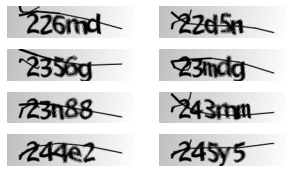

In [5]:
_,ax = plt.subplots(4,2, figsize=(5,3))

for i in range(8):
    img = cv2.imread(str(images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [6]:
test_labels
max_len = max([len(i) for i in test_labels])
min_len = min([len(i) for i in test_labels])
print("Maximum Length: ", max_len)
print("Maximum Length: ", min_len)

Maximum Length:  5
Maximum Length:  5


All Images seem to have the sampe shape and contain 5 letter Chaptchas that are crossed trough by a horizontal line.

Also there seems to be a small distracting line close to the first character of the captcha

# Extracting labelled characters

As we know that each of our image contains a line , basically a thin line which cuts several characters. So we are going to remove that line by morphological operations on our image(Erosion and dilation). First we wil threshold our image , we are gonna use Adaptive thresolding , then we will dilate to remove that line. Its also clearly visible that each image contains 5 characters and the positions of all 5 characters are always same. So we wil hardcode character's position and from each image we will extract five characters with their corresponding label , and hence will get a labelled data. We wil pad each character image to change it in required dimension.

Idea from 
https://www.kaggle.com/bharatbansal/ocr-with-opencv-92-9-accuracy-on-captcha-codes#Loading-images

In [7]:
kernel =np.ones((3,1),np.uint8)
borderType = cv2.BORDER_CONSTANT
def pad(src): 
    top = int(0.05 * src.shape[0])  # shape[0] = rows
    bottom = top
    left = int(0.15 * src.shape[1])  # shape[1] = cols
    right = left
    des=cv2.copyMakeBorder(src, top, bottom, left+1, right, borderType, None,255)
    return cv2.bitwise_not(des)

In [8]:
x_train=[]
y_train=[]
for image in images:
    im=cv2.imread(str(image),0)
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    s=str(image)
    for i in range(5):
        x_train.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
        y_train.append(s[-9+i])

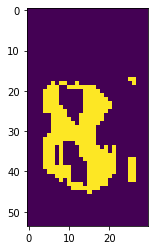

In [9]:
plt.imshow(x_train[102])

In [10]:
y_train[102]

'8'

In [11]:
type(x_train[45])

numpy.ndarray

In [12]:
len(x_train)

4710

In [13]:
x_train=np.array(x_train)
y_train=np.array(y_train)

We were working with a total of 942 images, that contained 5 letters each, therefore the total number of characters should be 4710, as seen above

In [14]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)


[['2' '241']
 ['3' '237']
 ['4' '259']
 ['5' '263']
 ['6' '241']
 ['7' '232']
 ['8' '246']
 ['b' '212']
 ['c' '238']
 ['d' '234']
 ['e' '209']
 ['f' '242']
 ['g' '236']
 ['m' '240']
 ['n' '482']
 ['p' '229']
 ['w' '211']
 ['x' '246']
 ['y' '212']]


The only big outlier seems to be the character "n" appearing 482 times

In [15]:


x_train=np.reshape(x_train,(-1,54,30,1))



In [16]:
y2_train = []
l=['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
for j in y_train:
    i=l.index(j)
    a=[]
    for r in range(19):
        if(r==i):
            a.append(1)
        else:
            a.append(0)
    a=np.array(a)
    y2_train.append(a)
y2_train=np.array(y2_train)   

# Preparing Test Data

In [17]:
x_test=[]
y_test=[]
for image in test_images:
    im=cv2.imread(str(image),0)
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    s=str(image)
    for i in range(5):
        x_test.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
        y_test.append(s[-9+i])

In [18]:
x_test=np.array(x_test)
y_test=np.array(y_test)

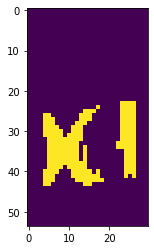

In [19]:
plt.imshow(x_test[21])

In [20]:
y_test[21]

'x'

In [21]:
x_test=np.reshape(x_test,(-1,54,30,1))

All of the possible characters will be transformed with an encoding from 0 to 18

In [22]:
y2_test = []
l=['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
for j in y_test:
    i=l.index(j)
    a=[]
    for r in range(19):
        if(r==i):
            a.append(1)
        else:
            a.append(0)
    a=np.array(a)
    y2_test.append(a)
y2_test=np.array(y2_test)  

# Inital Ideas
The dimension of the arrays in the current form is 4.
Therefore 2 different solutions to this problem can be applied:
1. Reduce the dimension to 2
2. Use CNNs

# Version 1: Reshape to 2D arrays


In [23]:
x_train.shape

(4710, 54, 30, 1)

In [24]:
nsamples, nx, ny, nz = x_train.shape
d2_x_train = x_train.reshape((nsamples,nx*ny*nz))

nsamples, nx, ny, nz = x_test.shape
d2_x_test = x_test.reshape((nsamples,nx*ny*nz))

## PCA
By performing a PCA, I'll try to identify, if dimensions of the 2d arrays can be reduced

In [25]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(d2_x_train)

PCA()

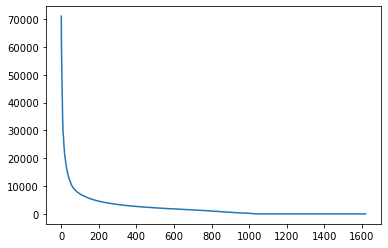

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(pca.singular_values_)

The values for all dimensions seem to be above 0, therefore the dimensions will not be reduced in this case.
Also the running time of the ML algorithms is adequate, therefore there is no need to risk even a small amount of information loss

## Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=3000,max_depth=None,n_jobs=-1)
rf_model = rf.fit(d2_x_train,y2_train)

In [28]:
from sklearn.metrics import classification_report
predictrf = rf_model.predict(d2_x_test)
print ("Random Forest:\n"+classification_report(y2_test, predictrf))

Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       0.95      0.70      0.81        30
           2       1.00      0.88      0.94        25
           3       1.00      0.83      0.91        18
           4       1.00      0.78      0.88        18
           5       1.00      0.88      0.94        26
           6       1.00      0.67      0.80        18
           7       1.00      0.82      0.90        28
           8       1.00      0.79      0.88        24
           9       0.88      0.88      0.88        25
          10       1.00      0.77      0.87        26
          11       0.96      0.83      0.89        29
          12       1.00      0.89      0.94        35
          13       1.00      0.89      0.94        35
          14       0.97      0.74      0.84        43
          15       0.96      1.00      0.98        24
          16       1.00      0.67      0.80        24
          17

/home/kromy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
from sklearn.metrics import f1_score
f1_score(y2_test, predictrf, average='weighted', labels=np.unique(predictrf))

0.8527583527583528

## KNN Classifier

In [30]:
from sklearn.neighbors import KNeighborsClassifier
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(d2_x_train,y2_train); 

In [31]:
predictkn = KNN_Classifier.predict(d2_x_test)
print ("KNN:\n"+classification_report(y2_test, predictkn))

KNN:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        24
           1       0.82      0.77      0.79        30
           2       0.92      0.92      0.92        25
           3       0.95      1.00      0.97        18
           4       1.00      0.89      0.94        18
           5       1.00      0.88      0.94        26
           6       1.00      0.50      0.67        18
           7       0.96      0.82      0.88        28
           8       0.95      0.83      0.89        24
           9       0.84      0.84      0.84        25
          10       1.00      0.92      0.96        26
          11       0.96      0.90      0.93        29
          12       1.00      0.91      0.96        35
          13       0.87      0.77      0.82        35
          14       0.79      0.88      0.84        43
          15       0.96      1.00      0.98        24
          16       0.92      1.00      0.96        24
          17       1.0

/home/kromy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
from sklearn.metrics import f1_score
f1_score(y2_test, predictkn, average='weighted', labels=np.unique(predictkn))

0.8566886769381266

# Version 2: Keras Sequential

In [33]:
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [34]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (50,30,1)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(19, activation = "softmax"))

In [35]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [36]:
batch_size = 86

In [37]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = False, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [38]:
datagen.fit(x_train)

In [39]:
history = model.fit(datagen.flow(x_train,y2_train, batch_size=batch_size),
                              epochs =  30, validation_data = (x_test,y2_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
54/54 [==============================] - 16s 283ms/step - loss: 4.1327 - accuracy: 0.0927 - val_loss: 2.2706 - val_accuracy: 0.2673
Epoch 2/30
54/54 [==============================] - 15s 276ms/step - loss: 2.5213 - accuracy: 0.1989 - val_loss: 1.4006 - val_accuracy: 0.5714
Epoch 3/30
54/54 [==============================] - 15s 278ms/step - loss: 1.7877 - accuracy: 0.4477 - val_loss: 0.8931 - val_accuracy: 0.7082
Epoch 4/30
54/54 [==============================] - 15s 281ms/step - loss: 1.2416 - accuracy: 0.6154 - val_loss: 0.6682 - val_accuracy: 0.7755
Epoch 5/30
54/54 [==============================] - 15s 282ms/step - loss: 0.8949 - accuracy: 0.7348 - val_loss: 0.5354 - val_accuracy: 0.8224
Epoch 6/30
54/54 [==============================] - 15s 283ms/step - loss: 0.7293 - accuracy: 0.7721 - val_loss: 0.3988 - val_accuracy: 0.8735
Epoch 7/30
54/54 [==============================] - 16s 287ms/step - loss: 0.6392 - accuracy: 0.8071 - val_loss: 0.3730 - val_accuracy: 0.8980

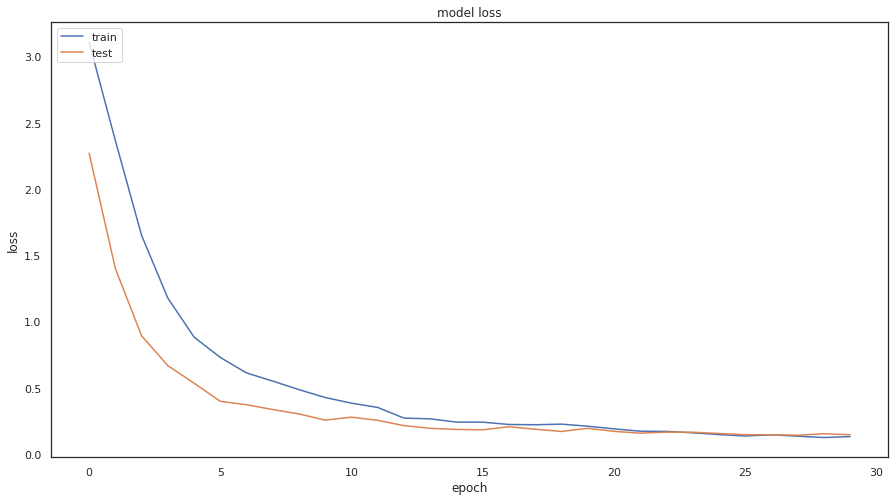

In [40]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

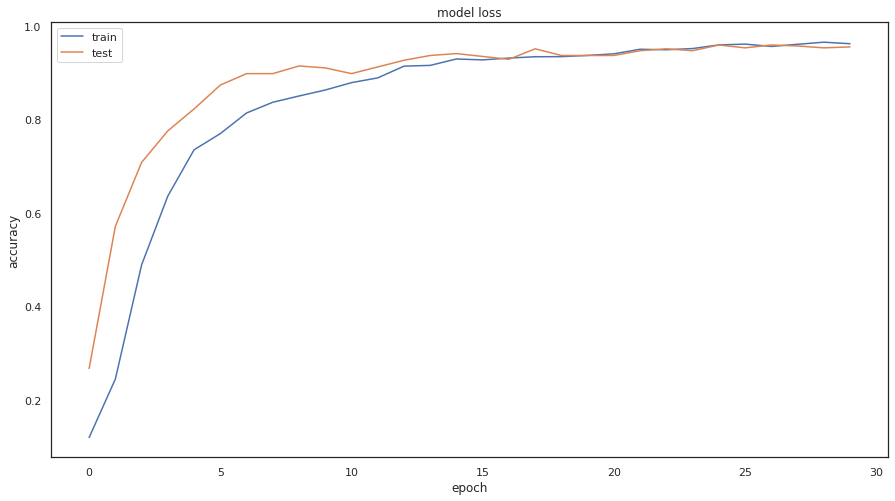

In [41]:
plt.figure(figsize=(15,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
print("The final accuracy is: ",history.history['accuracy'][-1])


The final accuracy is:  0.9619377255439758


Links:

https://www.kaggle.com/bharatbansal/ocr-with-opencv-92-9-accuracy-on-captcha-codes#Loading-images


https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi

https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec

https://www.tutorialspoint.com/jupyter/jupyter_notebook_markdown_cells.htm


# Predicting a single image

In [43]:
test_dir = Path("./test/")

In [44]:
image = list(test_dir.glob("*.png"))[9]

In [45]:
 im=cv2.imread(str(image),0)

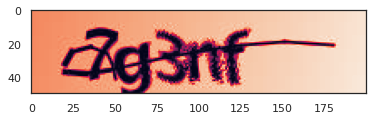

In [46]:


c = plt.imshow(im) 
plt.show() 

In [47]:
x_ex=[]
y_ex=[]

threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
erosion =cv2.dilate(threshold,kernel,iterations=2)
s=str(image)
for i in range(5):
    x_ex.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
    y_ex.append(s[-9+i])

'7'

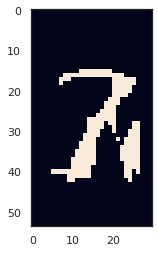

In [48]:
plt.imshow(x_ex[0])
y_ex[0]

'g'

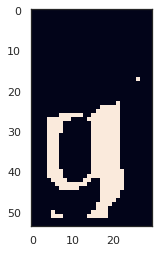

In [49]:
plt.imshow(x_ex[1])
y_ex[1]

'3'

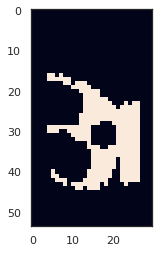

In [50]:
plt.imshow(x_ex[2])
y_ex[2]

'n'

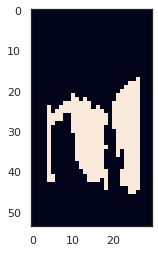

In [51]:
plt.imshow(x_ex[3])
y_ex[3]

'f'

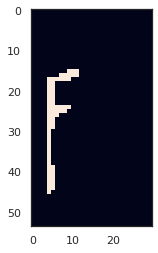

In [52]:
plt.imshow(x_ex[4])
y_ex[4]

In [53]:
x_ex=np.array(x_ex)
y_ex=np.array(y_ex)

In [54]:
x_ex=np.reshape(x_ex,(-1,54,30,1))

In [55]:
y2_ex = []
l=['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
for j in y_ex:
    i=l.index(j)
    a=[]
    for r in range(19):
        if(r==i):
            a.append(1)
        else:
            a.append(0)
    a=np.array(a)
    y2_ex.append(a)
y2_ex=np.array(y2_ex)  

In [56]:
Y_pred = model.predict(x_ex)


In [57]:
Y_pred.shape

(5, 19)

In [58]:
Y_pred

array([[1.63563456e-08, 4.64784167e-09, 8.82271890e-15, 7.10670911e-10,
        1.32006576e-11, 1.00000000e+00, 1.20581175e-15, 2.67285651e-13,
        7.46706841e-14, 1.50927925e-12, 7.02956050e-20, 6.32510103e-12,
        1.75610039e-14, 1.61307515e-14, 5.71538056e-14, 1.90055285e-12,
        1.01868861e-16, 7.86294085e-11, 9.05383712e-10],
       [1.04124261e-19, 1.38093861e-19, 3.16094853e-21, 1.67348024e-20,
        9.01262644e-17, 4.50182838e-20, 8.87501789e-20, 2.13146460e-15,
        3.36064830e-18, 2.95796330e-12, 6.77033435e-18, 2.53806885e-24,
        1.00000000e+00, 1.47153735e-21, 7.25298679e-18, 6.86246308e-17,
        1.26550786e-23, 1.10338323e-15, 2.53000747e-16],
       [7.55494734e-13, 1.00000000e+00, 1.62385232e-17, 2.30049703e-13,
        6.88504325e-16, 1.08759030e-13, 5.83801688e-11, 1.15502900e-18,
        2.75479330e-18, 1.79820793e-18, 3.05253363e-20, 1.49114774e-18,
        4.45531707e-16, 3.52898433e-21, 7.92840365e-19, 1.48344950e-17,
        2.05648673e-26

In [59]:
Y_pred_classes = np.argmax(Y_pred,axis=1)

In [60]:
Y_pred_classes

array([ 5, 12,  1, 14, 11])

In [61]:
Y_true_classes = np.argmax(y2_ex,axis = 1)


In [62]:
Y_true_classes

array([ 5, 12,  1, 14, 11])

In [63]:
for j in Y_pred_classes:
    print(l[j])

7
g
3
n
f
